In this notebook, We will be calculating technical indicators for an equity and then using nueral networks to forecast if it is a strong sell, sell, hold, buy or strong hold. The target variable for this exercise is the relative change in stock price with respect to the market (S&P 500). The signals are classified as follows:

 - if the relative change between the stock and the market is between -0.13 and -0.011, its a <b>strong sell signal</b>
 - if the relative change between the stock and the market is between -0.011 and -0.005, its a <b>sell signal</b>
 - if the relative change between the stock and the market is between -0.005 and 0.005, its a <b>hold signal</b>
 - if the relative change between the stock and the market is between 0.005 and 0.011, its a <b>buy signal</b>
 - if the relative change between the stock and the market is between 0.011 and 0.13, its a <b>strong buy signal</b>


These relative changes are based on a few technical indicators which are: SMA_20, Boolinger Bands, Stochastic Oscillator, Chaikin Money Flow, Exponential Weighted Moving Average, William_R, Donchian Channel, RSI Calculations, CCI Calculations along with stock price and volume information


In [1]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report

plt.xkcd()

## Step 1: Defining a function to calculate technical indicators and uses Ticker as an Input

In [2]:
def gain_function(number):
    if number>0:
        return number
    return 0

def loss_function(number):
    if number<0:
        return number*-1
    return 0


def create_technical_indicators(Ticker):
    df = yf.download(Ticker)
    ##Standard Moving Average
    df['SMA_20'] = df["Close"].rolling(window=20).mean()
    ##Boolinger Band Calculation
    standard_deviation = df["Close"].rolling(window=20).std()
    df['Boolinger_upper'] = df['SMA_20'] + 2*standard_deviation
    df['Boolinger_lower'] = df['SMA_20'] - 2*standard_deviation
    #Stochastic Oscillator
    c = df['Close']
    low_14 = df['Close'].rolling(window=14).min()
    high_14 = df['Close'].rolling(window=14).max()
    df['stochastic_oscillator']= ((c-low_14)/(high_14-low_14))*100
    #Chaikin Money Flow
    CMF_close = df['Close']
    CMF_low = df['Low']
    CMF_high = df['High']
    CMF_volume = df['Volume'].rolling(20).sum()
    step_1= ((CMF_close-CMF_low)/(CMF_high-CMF_close))/(CMF_high-CMF_low)
    step_2= step_1 *CMF_volume
    step_2b= step_2.rolling(20).sum()
    df['Chaikin_money_flow']= step_2b/CMF_volume
    #Exponential Weighted Moving Average
    df['Ewma']= pd.Series.ewm(df['Close'],span=30).mean()
    #Moving Average Convergence Divergence 
    df['MACD'] = pd.Series.ewm(df['Close'],span=12).mean() - pd.Series.ewm(df['Close'],span=26).mean()
    #William_R
    close_williams = df['Close']
    close_max = df['Close'].rolling(14).max()
    close_min = df['Close'].rolling(14).min()
    df['williams_r'] = ( close_max - close_williams)/ (close_max - close_min) *-100
    #Donchian Channel
    df['high_dc'] = df['Close'].rolling(20).max()
    df['low_dc'] = df['Close'].rolling(20).min()
    df['middle_dc'] = (df['high_dc']+  df['low_dc'])/2
    

    ## RSI Calculations
    rsi_delta_price = df['Close'] - df['Close'].shift(1)
    rsi_df = (rsi_delta_price.to_frame()).dropna()
    rsi_df['Gain'] = rsi_df['Close'].apply(gain_function)
    rsi_df['Loss'] = rsi_df['Close'].apply(loss_function)
    rsi_df['Avg_gain'] = (rsi_df['Gain'].rolling(14)).mean()
    rsi_df['Avg_loss'] = (rsi_df['Loss'].rolling(14)).mean()
    rsi_df.dropna(inplace = True)
    rsi_df['RS'] = rsi_df['Avg_gain']/rsi_df['Avg_loss']
    df['RSI'] = 100-(100/(1+rsi_df['RS']))

    ## CCI Calculations

    TP = (df['High'] + df['Low'] + df['Close']) / 3
    df['CCI'] = ((TP-TP.rolling(20).mean()))/(0.015*TP.rolling(20).std())
    
    df.reset_index(inplace = True)
    df.dropna(inplace = True)
    #df.to_excel(Ticker+"_technical_indicators.xlsx", sheet_name=Ticker)
    
    return df


For the purpose of this exercise, I am working the Nvidia Corporation (NVDA). The data for S&P and NVDA is imported below from yahoo finance

In [3]:
stock = create_technical_indicators("NVDA")
SP = yf.download("^GSPC")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
stock['pct_change']=stock['Adj Close'].pct_change(periods=1).astype(float)
stock.set_index("Date",inplace = True)

SP['SP_pct_change'] = SP['Adj Close'].pct_change(periods=1).astype(float)

stock = stock.merge(SP['SP_pct_change'], left_index=True, right_index=True)

stock['relative_change'] = stock['pct_change'] - stock['SP_pct_change']

stock.dropna(inplace=True)

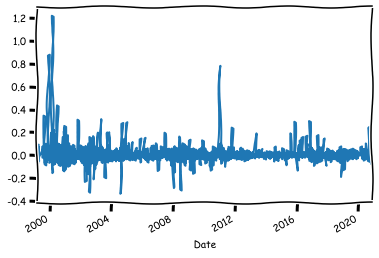

In [5]:
## A plot to see the values of relative change in the stock price and S&P price

stock.relative_change.plot()

In [6]:
stock.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_20,Boolinger_upper,Boolinger_lower,stochastic_oscillator,...,MACD,williams_r,high_dc,low_dc,middle_dc,RSI,CCI,pct_change,SP_pct_change,relative_change
Date,,,,,,,,,,,,,,,,,,,,,
1999-03-19,1.739583,1.802083,1.739583,1.750000,1.609447,2632800.0,1.782031,1.937136,1.626927,50.000000,...,0.004934,-50.000000,1.979167,1.661458,1.820312,43.307090,-21.018061,0.002985,-0.013110,0.016095
1999-03-22,1.786458,1.791667,1.697917,1.697917,1.561547,916800.0,1.779427,1.938494,1.620360,20.588200,...,0.000610,-79.411800,1.979167,1.661458,1.820312,41.044777,-47.255658,-0.029762,-0.001755,-0.028007
1999-03-23,1.708333,1.708333,1.562500,1.593750,1.465747,4099200.0,1.767448,1.944492,1.590404,0.000000,...,-0.010790,-100.000000,1.979167,1.593750,1.786458,42.307696,-112.390265,-0.061350,-0.026885,-0.034465
1999-03-24,1.583333,1.593750,1.520833,1.583333,1.456167,1521600.0,1.747656,1.913170,1.582142,0.000000,...,-0.020395,-100.000000,1.916667,1.583333,1.750000,44.000001,-146.641272,-0.006536,0.005110,-0.011646
1999-03-25,1.578125,1.666667,1.572917,1.604167,1.475327,1008000.0,1.732031,1.889155,1.574907,8.163237,...,-0.026071,-91.836763,1.838542,1.583333,1.710938,36.936930,-108.856718,0.013158,0.016869,-0.003711


## Step 2: Converting target variable to a categorical variable

In [7]:

bins=[-0.1300, -0.011, -0.005, 0.005, 0.011, 0.1300]
group_names = ['strong sell', 'sell', 'hold', 'buy', 'strong buy']
stock['short_result'] = pd.cut(stock['relative_change'], bins=bins, labels=group_names)
stock.dropna(inplace=True)
stock['short_result'].unique()


[strong buy, strong sell, hold, buy, sell]
Categories (5, object): [strong sell < sell < hold < buy < strong buy]

In [8]:
label_result = LabelEncoder()
stock['short_result'] = label_result.fit_transform(stock['short_result'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


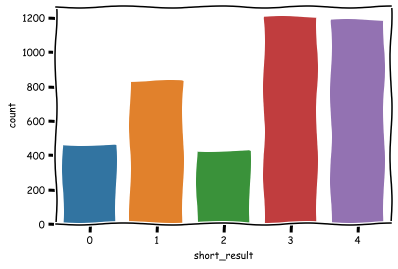

In [9]:

sns.countplot(stock['short_result'])

## Step 3: Splitting Data and Training the model

In [10]:
X = stock.drop(['short_result'], axis=1)
y = stock['short_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)


    

In [11]:
mlpc = MLPClassifier(hidden_layer_sizes=(10,10,10,10), max_iter=1000,solver='sgd')
mlpc.fit(X_train, y_train)
mlpc_clf = mlpc.predict(X_test)

## Step 4: Evaluating the performance of the nueral network classifier

In [12]:
# See how our model performed
print(classification_report(y_test, mlpc_clf))

              precision    recall  f1-score   support

           0       0.69      0.68      0.68        87
           1       0.83      0.80      0.81       172
           2       0.64      0.70      0.67        89
           3       1.00      0.89      0.94       255
           4       0.89      1.00      0.94       219

    accuracy                           0.86       822
   macro avg       0.81      0.81      0.81       822
weighted avg       0.86      0.86      0.86       822



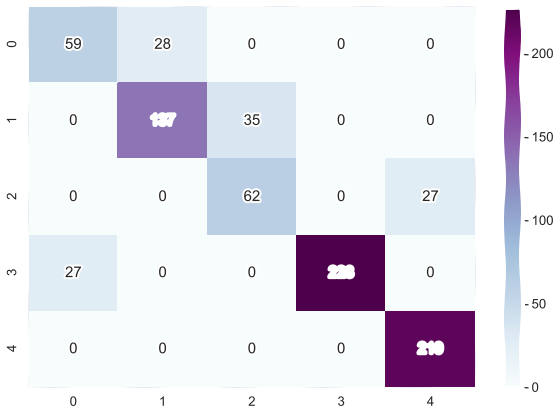

In [13]:
array = confusion_matrix(y_test, mlpc_clf)

df_cm = pd.DataFrame(array, range(5), range(5))
plt.figure(figsize=(10,7))
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 15},cmap='BuPu',fmt='d') # font size

plt.show()